# Pre-trained Model(FastAI) + LJP

In [8]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [9]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Fastai - ULMFiT

- Reference : Kaggle
    - [Introduction to NLP using Fastai2 and ULMFiT](https://www.kaggle.com/code/harish3110/introduction-to-nlp-using-fastai2-and-ulmfit)

- ULMFiT
    - Universal Language Model Fine-tuning for Text Classification
    - https://arxiv.org/abs/1801.06146

This will have two parts:

- Training the Language Model
- Training the Classifier Model

## Load Data

In [10]:
import os
from pathlib import Path

path = Path(os.getcwd() + '/datasets')

In [11]:
train = pd.read_csv(path / 'train.csv')
test = pd.read_csv(path / 'test.csv')
submission = pd.read_csv(path / 'sample_submission.csv')

In [6]:
train.shape, test.shape

((2478, 5), (1240, 4))

## DataBlock

In [7]:
from fastai.text.data import TextBlock

In [9]:
db_lm = DataBlock(
    blocks=TextBlock.from_df('facts', is_lm=True, tok_text_col='facts'),
    get_x=ColReader('facts'),
    splitter=RandomSplitter(0.1))

dls_lm = db_lm.dataloaders(train, bs=64, seq_len=72)
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj curtis xxmaj lee xxmaj kyles was charged with murdering 60 - year - old xxmaj xxunk xxmaj dye in a xxmaj xxunk ’s parking lot . xxmaj after an initial trial with a hung jury , xxmaj kyles was tried again , convicted of first - degree murder , and sentenced to death . xxmaj the xxup u.s . xxmaj supreme xxmaj court affirmed the decision on direct appeal .","xxmaj curtis xxmaj lee xxmaj kyles was charged with murdering 60 - year - old xxmaj xxunk xxmaj dye in a xxmaj xxunk ’s parking lot . xxmaj after an initial trial with a hung jury , xxmaj kyles was tried again , convicted of first - degree murder , and sentenced to death . xxmaj the xxup u.s . xxmaj supreme xxmaj court affirmed the decision on direct appeal . xxmaj"
1,"transactional records obtained by the government include the date and time of calls , and the xxunk location where calls began and ended based on their connections to cell xxunk site "" location information ( xxunk ) . \n xxmaj based on the cell - site evidence , the government charged xxmaj timothy xxmaj carpenter with , among other offenses , aiding and abetting robbery that affected interstate commerce , in violation","records obtained by the government include the date and time of calls , and the xxunk location where calls began and ended based on their connections to cell xxunk site "" location information ( xxunk ) . \n xxmaj based on the cell - site evidence , the government charged xxmaj timothy xxmaj carpenter with , among other offenses , aiding and abetting robbery that affected interstate commerce , in violation of"


In [10]:
x, y = dls_lm.one_batch()
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

## 1. LM

In [12]:
from fastai.text.learner import language_model_learner
from fastai.text.models import AWD_LSTM

In [14]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [15]:
learn.validate()

(#3) [3.745239734649658,0.36798879504203796,42.319149017333984]

### FineTuning - Head

SuggestedLRs(valley=0.00363078061491251)

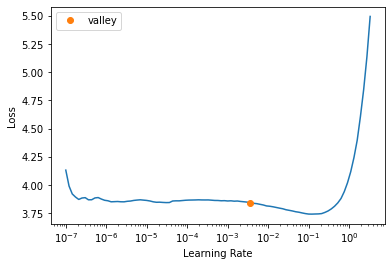

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.659774,3.497470,0.386775,33.031765,00:26


In [18]:
learn.save('ulmfit_head')
learn.load('ulmfit_head')

### FineTuning - Body

SuggestedLRs(valley=0.0002290867705596611)

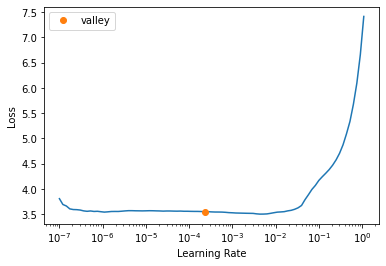

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
learn.fit_one_cycle(8, lr_max = slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.447324,3.301403,0.402998,27.150705,00:31
1,3.248369,3.127143,0.418260,22.808714,00:31
2,3.028604,3.026946,0.427674,20.634121,00:31
3,2.854047,2.984156,0.431275,19.769817,00:31
4,2.716268,2.969008,0.434192,19.472593,00:31
5,2.601345,2.965858,0.434928,19.411350,00:31
6,2.551855,2.967016,0.435184,19.433851,00:31
7,2.519206,2.967567,0.435404,19.444553,00:31


In [21]:
learn.save('ulmfit_fine_tuned')
learn.load('ulmfit_fine_tuned')
learn.save_encoder('ulmfit_ftuned_encoder')

### LM Testing

In [22]:
TEXT = "Kyles was tried again , convicted of first - degree murder , and"
N_WORDS = 20
N_SENTENCES = 2

In [23]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Kyles was tried again , convicted of first - degree murder , and sentenced to death . His conviction was based on the evidence obtained from a jury in Arizona state
Kyles was tried again , convicted of first - degree murder , and sentenced to death for the murder of her mother . 
 In 1998 , Mr . Schwab


## 2. Classification Model

### Data preperation

In [24]:
blocks = (TextBlock.from_df('facts', vocab=dls_lm.vocab, seq_len=dls_lm.seq_len, tok_text_col='facts'), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('facts'),
                get_y=ColReader('first_party_winner'),
                splitter=RandomSplitter(0.15))

In [25]:
dls = dls.dataloaders(train, bs=64)

In [26]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj on xxmaj august 5 , 2008 , xxmaj joel xxmaj perez and xxmaj carlos xxmaj cruz drove to a xxmaj shell station in xxmaj arlington xxmaj heights , xxmaj illinois , with xxmaj cruz at the wheel . xxmaj they met with xxmaj xxunk xxmaj diaz , who was working with xxmaj drug xxmaj enforcement xxmaj agency ( "" dea "" ) officials . xxmaj diaz instructed them to meet him at a different location to complete the deal . xxmaj instead , xxmaj perez walked to a nearby xxmaj denny 's , where xxmaj alexander xxmaj vasquez waited for him in the driver 's seat of a black xxmaj pontiac xxmaj bonneville . xxmaj perez got into the passenger seat of the xxmaj bonneville and called xxmaj cruz , telling him that he was not willing to follow xxmaj diaz . xxmaj cruz walked to the xxmaj",0
1,"xxbos xxmaj in the words of the xxmaj ninth xxmaj circuit decision below , “ [ xxunk case arises out of a complex set of bankruptcy proceedings . ” \n xxmaj petitioner xxmaj bradley xxmaj taggart is a real estate developer who owned 25 % interest in xxmaj xxunk xxmaj park xxmaj business xxmaj center ( “ spbc ” ) . xxmaj respondents xxmaj terry xxmaj emmert and xxmaj keith xxmaj jehnke also each owned a 25 % interest in xxup spbc . xxmaj in 2007 , xxmaj taggart purported to transfer his share of xxup spbc to his attorney , xxmaj john xxmaj berman . \n xxmaj emmert and xxmaj jehnke sued xxmaj taggart and xxmaj berman in xxmaj oregon state court , alleging that the transfer violated spbc ’s operating agreement by not allowing xxmaj emmert and xxmaj jehnke the right of first refusal . xxmaj emmert and",1
2,"xxbos xxmaj in 1993 , a tax auditor for the xxmaj franchise xxmaj tax xxmaj board of xxmaj california ( ftb ) read a newspaper about xxmaj gilbert xxup p. xxmaj hyatt , an inventor , and the large amounts of money he was making from the patent . xxmaj the auditor decided to investigate xxmaj hyatt , and , after finding some discrepancies , opened an audit on xxmaj hyatt ’s 1991 state tax return . xxmaj in conducting the audit , the auditor found additional discrepancies ▁ surrounding xxmaj hyatt ’s move from xxmaj california to xxmaj nevada and opened an audit as to his 1992 tax returns . xxup ftb determined that xxmaj hyatt owed $ xxunk million in state income taxes , plus $ xxunk million in penalties and $ 1.2 million in interest , resulted in a tax assessment of $ xxunk million for xxmaj",1


In [27]:
len(dls.train_ds), len(dls.valid_ds)


(2107, 371)

### Load fine-tuned Model

In [28]:
from fastai.text.all import *

In [30]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, FBeta(beta=1)]).to_fp16()
learn.load_encoder('ulmfit_ftuned_encoder')

In [31]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(9512, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(9512, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


SuggestedLRs(valley=0.007585775572806597)

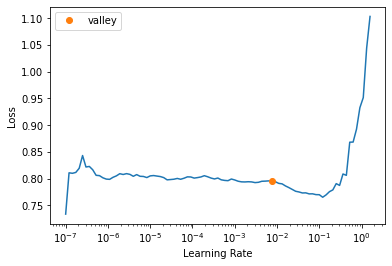

In [32]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.725059,0.644162,0.625337,0.739212,00:09


SuggestedLRs(valley=0.00363078061491251)

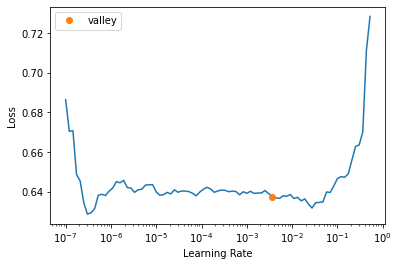

In [34]:
learn.lr_find()

### Gradual unfreezing

In [35]:
## Applying gradual unfreezing of one layer after another

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.664037,0.636472,0.638814,0.755474,00:10


In [36]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.633595,0.626010,0.668464,0.791171,00:14


In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),3e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.586074,0.619031,0.668464,0.786828,00:18
1,0.544107,0.644755,0.687332,0.802048,00:18


In [38]:
learn.save('final_model')

Path('models/final_model.pth')

In [39]:
learn.export()

## Submission

In [42]:
test = pd.read_csv(path/'test.csv')

In [43]:
dl = learn.dls.test_dl(test['facts'])

In [44]:
preds = learn.get_preds(dl=dl)

In [45]:
preds[0][0].cpu().numpy()

array([0.34820172, 0.6517983 ], dtype=float32)

In [46]:
preds[0][0].cpu().argmax(dim=-1)

tensor(1)

In [51]:
submission['first_party_winner'] = preds[0].argmax(dim=-1)

In [52]:
submission.head()

,ID,first_party_winner
0,TEST_0000,1
1,TEST_0001,1
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,1


In [56]:
submission.to_csv('./fastai+LSTM.csv', index=False)
print('Done')

Done


In [58]:
submission['first_party_winner'].value_counts()

1    1046
0     194
Name: first_party_winner, dtype: int64

In [59]:
train['first_party_winner'].value_counts()

1    1649
0     829
Name: first_party_winner, dtype: int64

## Conclusion

- 1로 지나치게 많이 예측하는 문제는 여전함 (정확도는 올라가나 '재현률'이 낮아지는 문제...)
- 생각보다 성능향상이 별로 없다... 시무룩...